In [1]:
# Essential Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold

# visualization
import matplotlib.pyplot as plt
import seaborn as sns 

# Algorithms
from sklearn.ensemble import IsolationForest
from prophet import Prophet

# Model performance evaluation
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error

#from minisom import MiniSom
#from tslearn.barycenters import dtw_barycenter_averaging
#from tslearn.clustering import TimeSeriesKMeans
#from sklearn.cluster import KMeans

In [2]:
import glob
import pandas as pd

def pd_read_pattern(pattern, filesNo):
    files = glob.glob(pattern)
    print(len(files))
    df = pd.DataFrame()
    fc =0
    for f in files:
        if fc >= filesNo:
            break    
        # Concat Instead of append
        df = pd.concat([df,pd.read_csv(f, low_memory=False)])
        fc += 1
        
        

    return df.reset_index(drop=True)

ztedf = pd_read_pattern('..\ZTE_NBI\CallAccess_FDD_[0-9]*.csv', 50)
ztedf.head()

48


,Begin Time,End Time,Granularity,SubnetWork ID,SubnetWork Name,ManagedElement ID,Managed Element,eNodeB ID,eNodeB Name,E-UTRAN FDD Cell ID,...,Number of Cell DRB Admission Failure due to Not Enough CPU Resource(times),Number of Cell DRB Admission Failure due to PHY Resource Allocated Failure(times),Number of Cell Admission Failure due to Service Cell Other Parameters Modification(times),Number of Cell Admission Failure due to Target PLMN selected Failure(times),Number of Cell Admission Failure due to RRC Connection Number License Prohibit(times),Number of Cell Admission Failure due to E-RAB Number License Prohibit(times),Cell Service Time(s),Maximum Number of RRC Connection User(unit),Number of E-RAB HO Incoming Admission Request(unit),Number of E-RAB(QCI7) HO Incoming Admission Request(unit)
0,2023-01-31 00:00:00,2023-01-31 00:15:00,15 minutes,1,1(1),5003,PAF003(5003),280-20_5003,PAF003,21,...,0,0,0,0,0,0,900,9,16,1
1,2023-01-31 00:00:00,2023-01-31 00:15:00,15 minutes,1,1(1),5003,PAF003(5003),280-20_5003,PAF003,22,...,0,0,0,0,0,0,900,13,14,3
2,2023-01-31 00:00:00,2023-01-31 00:15:00,15 minutes,1,1(1),5003,PAF003(5003),280-20_5003,PAF003,23,...,0,0,0,0,0,0,900,13,52,5
3,2023-01-31 00:00:00,2023-01-31 00:15:00,15 minutes,1,1(1),5003,PAF003(5003),280-20_5003,PAF003,31,...,0,0,0,0,0,0,900,2,1,0
4,2023-01-31 00:00:00,2023-01-31 00:15:00,15 minutes,1,1(1),5003,PAF003(5003),280-20_5003,PAF003,32,...,0,0,0,0,0,0,900,2,18,3


In [3]:
import numbers
import numpy as np
    
def findValidMetrics(df,firstMetricPos):
    #isinstance(df[m], numbers.Number),
    #df = ztedf.copy()
    metrics_list = df.columns.tolist()[firstMetricPos:]
    metrics_list_fin = []
    for m in metrics_list:
        #print('{} {}'.format(m,df[m].dtype))
        if df[m].dtype == np.int64 or df[m].dtype == np.float64:
            r = df[m].sum()
            if r != 0:
                metrics_list_fin.append(m)
    
    return metrics_list_fin

lables = findValidMetrics(ztedf,14)
len(lables)

79

#### Site with Incidents with this period:
- PAF024	2023-01-03 03:13:00.0000000
- PAF024	2023-02-01 06:16:00.0000000
- LIM090	2023-02-05 17:53:00.0000000
- LIM003	2023-03-17 12:33:00.0000000
- PAF031	2023-03-29 08:37:00.0000000

In [4]:
# Granularity 15 minutes
#df.columns.tolist()[3:14]
eNodeB = ztedf['eNodeB Name'].unique()
cellName = ztedf['E-UTRAN\xa0FDD\xa0Cell Name'].unique()
eNodeB

sitesUnderStudy = ['PAF024','LIM090','LIM003','PAF031']

<Axes: xlabel='eNodeB Name'>

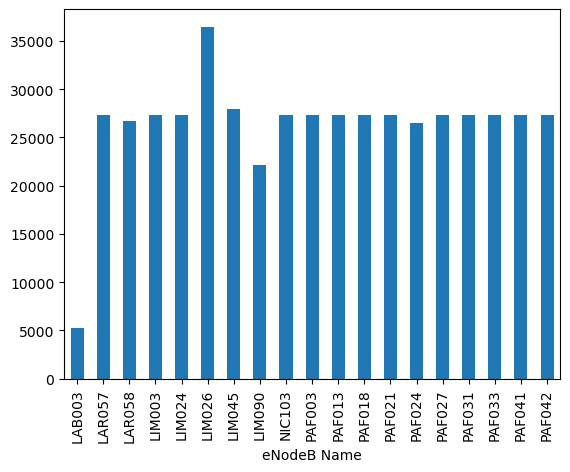

In [5]:
#inspect the categorrical atribluts 
df_plt = ztedf.groupby(['eNodeB Name']).count()['Begin Time']
df_plt.plot.bar()
#df_plt.reset_index().rename(columns={'id':'RecordCount'}).set_index('status').T

In [6]:
# Check for missing values
def getMissingValues(df):
    columns_missing_values = {}
    for c in df.columns:
        msv = df[df[c].isna()| df[c].eq(' ')].shape[0]
        if msv > 0:
            columns_missing_values[c] = (msv,msv/df.shape[0]*100)
    return columns_missing_values
    

In [7]:
## the the datatime index and group the data by hour
def getDatasetForSite(df,metrics, sitecode, cut_off_date, windowHours):
    df = df.loc[ztedf['eNodeB Name']==sitecode].copy()
    df = df.drop_duplicates()
    df['datetime'] = pd.to_datetime(df['Begin Time'])
    df = df.set_index('datetime')
    df  = df[metrics]
    
    cut_off_date = pd.to_datetime(cut_off_date)
    start_date = cut_off_date - pd.Timedelta(windowHours, unit="H")
    print(start_date, cut_off_date)
    df =  df.loc[(df.index >= start_date)&(df.index < cut_off_date)]
    
    #df['datetime'] = df['date'].dt.strftime('%Y%m') 
    ### Group by date to take the mean value of Cells
    df  = df.groupby([pd.Grouper(freq='H', level='datetime')]).mean()
    
    #df  = df[metrics].groupby(['datetime']).mean() 
    ### Aggr the data by Hour
    #df = df.resample('H').mean() 
    #df = df.dropna()

    return df
 
#end_date = pd.date.('2023-02-06', '%d/%m/%y')    
dfdata = getDatasetForSite(ztedf,lables,'LIM003','2023-03-18',72)
print(dfdata.shape)
#dfdata.index.min()
dfdata.describe().T


#dfdata = dfdata.dropna()
#dfdata[~(dfdata==0)]

#getMissingValues(dfdata)
#df_date = df_date.rolling(window=1).mean()
#df_date = df_date.dropna()

2023-03-15 00:00:00 2023-03-18 00:00:00
(72, 79)


,count,mean,std,min,25%,50%,75%,max
Number of Mo-Data RRC Establishment Failure due to Timeout(times),72.0,0.091049,0.104661,0.000000,0.000000,0.041667,0.166667,0.416667
Number of Mo-Signalling RRC Establishment Failure due to Other Reason(times),72.0,0.000579,0.004910,0.000000,0.000000,0.000000,0.000000,0.041667
Number of mo-VoiceCall RRC Establishment Failure due to Timeout(times),72.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Number of Mt-Access RRC Establishment Failure due to Timeout(times),72.0,0.036458,0.054141,0.000000,0.000000,0.000000,0.041667,0.208333
Number of Mo-Signalling RRC Establishment Failure due to Timeout(times),72.0,0.189815,0.204589,0.000000,0.041667,0.125000,0.250000,0.791667
...,...,...,...,...,...,...,...,...
Number of Cell Admission Failure due to PHY Resource Allocated Failure(times),72.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Number of Cell Admission Failure due to Other Reason(times),72.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Cell Service Time(s),72.0,888.859375,66.445416,480.250000,900.000000,900.000000,900.000000,900.000000
Maximum Number of RRC Connection User(unit),72.0,16.036844,7.811334,4.833333,8.677083,17.291667,21.583333,33.541667


In [8]:
#for c in dfdata.columns:
#    if dfdata[c].mean() !=0:
#        print(c)

In [9]:
# Normalized Values with StandardScaler or MinMaxScaler
# Use the VarianceThreshold feature_selection to remove all low-variance features.

def dataPreprocessing(df):
    labels = df.columns
   
    # Min Max Scaler
    scaler = StandardScaler() # MinMaxScaler((0, 1)) 
    x = scaler.fit_transform(df[labels])
    
    for i in range(len(labels)):
        df[labels[i]] = x.T[i]
        
    #maxVal = max(df[labels].max())
    #stdVal = np.std(df[labels].max())
    #    print(minVal, maxVal, (maxVal * (minVal - maxVal)))
    #(.8 * (1 - .8))
    
    sel = VarianceThreshold() 
    x = sel.fit_transform(df)
    
    var = sel.get_feature_names_out()
    #dfnew = pd.DataFrame(data=x, columns=var)

    return df[var]
    
dfdata_norm = dataPreprocessing(dfdata)
print(dfdata_norm.shape)
#dfdata_norm.describe().T

#getMissingValues(dfnew)
#dfnew.plot(subplots=True, figsize=(20, 12))

(72, 47)


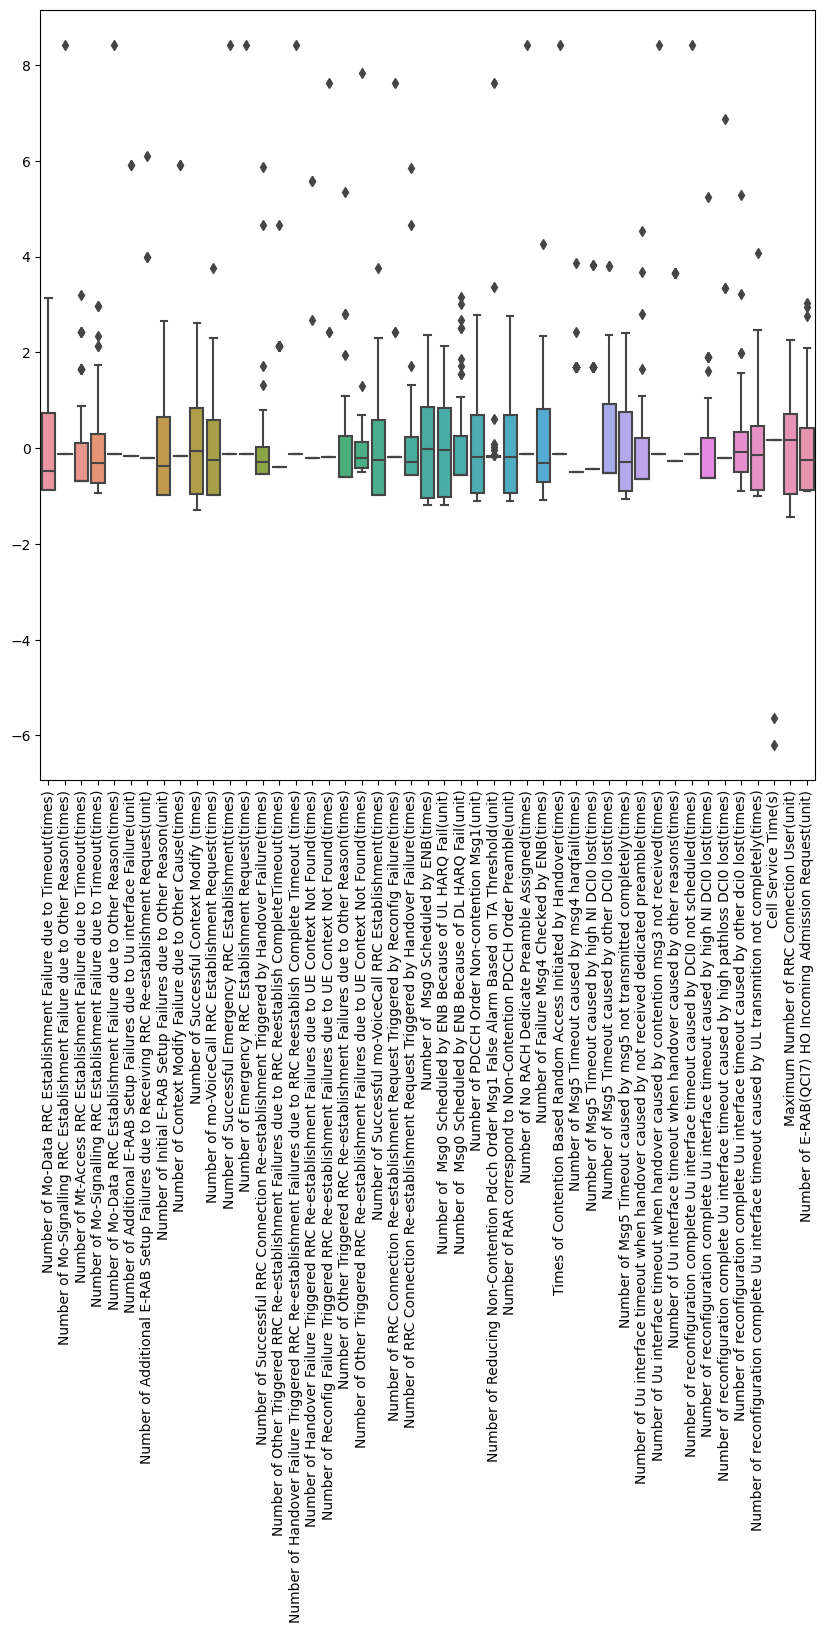

In [10]:
### Plot Outliers
plt.figure(figsize=(10,10))
sns.boxplot(data=dfdata_norm)
plt.xticks(rotation=90)
plt.show()

## Abnormal Detection using IsolationForest
####  Use all data features

In [11]:
# Set the percentage of outliers to be detected
outliers_fraction = 0.05

# Initialize the Isolation Forest algorithm
model = IsolationForest(contamination=outliers_fraction)

data = dfdata_norm.copy()
# Fit the model to the data
model.fit(data)

# Predict the outliers using the trained model
outliers = model.predict(data)

# Add the outlier predictions to the original data as a new column
data['outliers'] = outliers

# Filter the original data to only include the non-outliers
outliers = data[data['outliers'] == -1]
outliers

C:\ProgramData\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


,Number of Mo-Data RRC Establishment Failure due to Timeout(times),Number of Mo-Signalling RRC Establishment Failure due to Other Reason(times),Number of Mt-Access RRC Establishment Failure due to Timeout(times),Number of Mo-Signalling RRC Establishment Failure due to Timeout(times),Number of Mo-Data RRC Establishment Failure due to Other Reason(times),Number of Additional E-RAB Setup Failures due to Uu interface Failure(unit),Number of Additional E-RAB Setup Failures due to Receiving RRC Re-establishment Request(unit),Number of Initial E-RAB Setup Failures due to Other Reason(unit),Number of Context Modify Failure due to Other Cause(times),Number of Successful Context Modify (times),...,Number of Uu interface timeout when handover caused by other reasons(times),Number of reconfiguration complete Uu interface timeout caused by DCI0 not scheduled(times),Number of reconfiguration complete Uu interface timeout caused by high NI DCI0 lost(times),Number of reconfiguration complete Uu interface timeout caused by high pathloss DCI0 lost(times),Number of reconfiguration complete Uu interface timeout caused by other dci0 lost(times),Number of reconfiguration complete Uu interface timeout caused by UL transmition not completely(times),Cell Service Time(s),Maximum Number of RRC Connection User(unit),Number of E-RAB(QCI7) HO Incoming Admission Request(unit),outliers
datetime,,,,,,,,,,,,,,,,,,,,,
2023-03-16 13:00:00,1.128467,-0.118678,0.871875,1.731863,-0.118678,-0.169031,-0.204211,1.851134,5.916080,1.455264,...,-0.273179,-0.118678,1.053534,-0.196116,-0.492628,1.132277,0.168842,1.311283,1.743001,-1
2023-03-16 15:00:00,1.529370,-0.118678,1.646876,2.347131,-0.118678,-0.169031,-0.204211,2.052974,-0.169031,0.486914,...,-0.273179,-0.118678,0.213817,-0.196116,-0.080195,0.730681,0.168842,0.795613,0.478788,-1
2023-03-17 12:00:00,0.727565,8.426150,-0.678125,0.091151,8.426150,5.916080,-0.204211,-0.369106,-0.169031,0.029638,...,-0.273179,-0.118678,0.213817,3.333974,-0.492628,0.329086,-6.192705,0.172512,0.561236,-1
2023-03-17 13:00:00,1.128467,-0.118678,0.871875,2.962398,-0.118678,-0.169031,3.996701,-0.369106,-0.169031,1.670453,...,3.660601,-0.118678,5.252120,-0.196116,5.281435,4.077314,-5.626266,1.037333,0.533754,-1


Number of Mo-Signalling RRC Establishment Failure due to Other Reason(times)


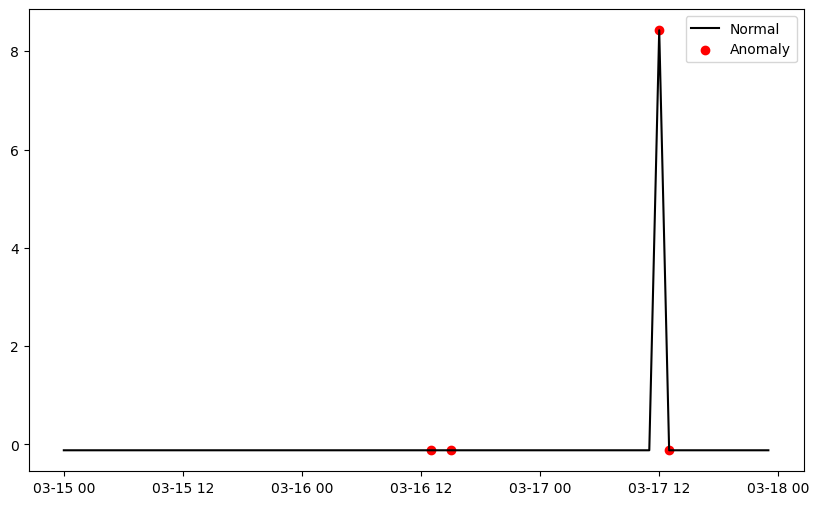

In [14]:
col = data.columns[1]
print(col)
fig, ax = plt.subplots(figsize=(10,6))
a = data.loc[data['outliers'] == -1, col] #anomaly
ax.plot(data.index, data[col], color='black', label = 'Normal')
ax.scatter(a.index,a, color='red', label = 'Anomaly')
plt.legend()
plt.show();

## Abnormal Detection using IsolationForest
####  Select only one  feature

In [15]:
col = dfdata_norm.columns[1]
df = dfdata_norm[col].copy()
df = df.to_frame()

print(col)

outliers_fraction = float(.02)
scaler = StandardScaler()
np_scaled = scaler.fit_transform(df.values.reshape(-1, 1))
data = pd.DataFrame(np_scaled)
# train isolation forest
model =  IsolationForest(contamination=outliers_fraction)
model.fit(data)

df['anomaly'] = model.predict(data)

Number of Mo-Signalling RRC Establishment Failure due to Other Reason(times)


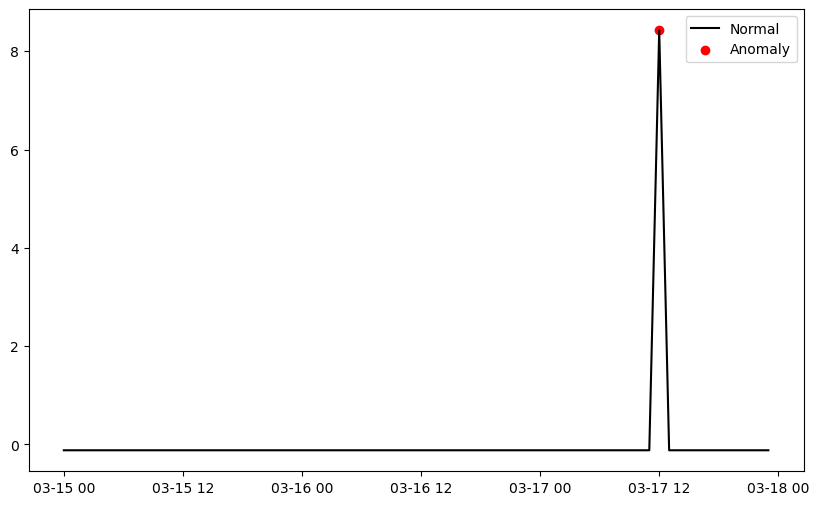

In [17]:
fig, ax = plt.subplots(figsize=(10,6))
a = df.loc[df['anomaly'] == -1, col] #anomaly
ax.plot(df.index, df[col], color='black', label = 'Normal')
ax.scatter(a.index,a, color='red', label = 'Anomaly')
plt.legend()
plt.show();

## Abnormal Detection using the Prophet library
####  Find the outliers in time series

23:35:50 - cmdstanpy - INFO - Chain [1] start processing


Number of Mo-Signalling RRC Establishment Failure due to Other Reason(times)


23:35:51 - cmdstanpy - INFO - Chain [1] done processing


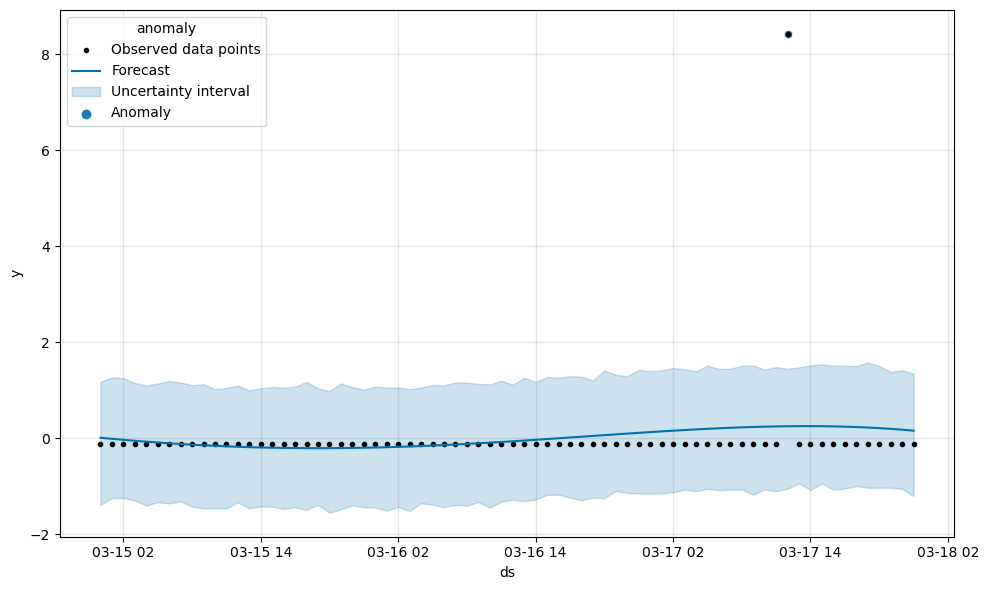

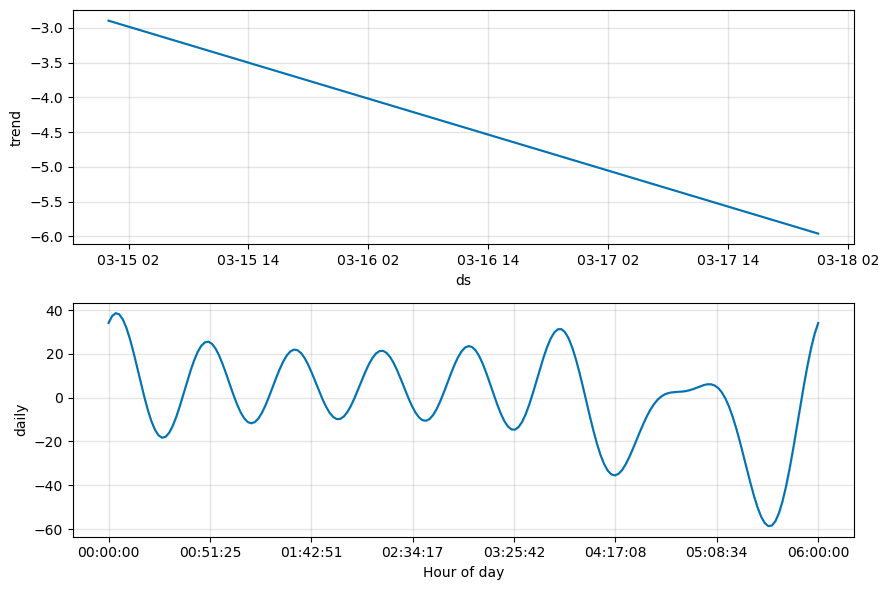

In [29]:
def getOutlier(df, column_index):

    # Add seasonality
    model = Prophet(seasonality_mode='multiplicative')
    #, interval_width=0.99,yearly_seasonality=True, weekly_seasonality=True)
    #model.add_seasonality('monthly', period=91.25, fourier_order=8, mode='additive')
    model.add_seasonality('daily', period=91.25, fourier_order=8, mode='additive')
    #model.add_regressor('regressor', mode='additive')

    col = df.columns[column_index]
    print(col)
    # Fit the model on the training dataset
    data = df[col].reset_index()
    data.columns = ['ds', 'y']
    
    # Fit the model on the training dataset
    model.fit(data)
    
    #future = model.make_future_dataframe(periods=3)
    # Make prediction
    forecast = model.predict(data)
    
    # Visualize the forecast
    model.plot(forecast); # Add semi-colon to remove the duplicated chart
      
    # Merge actual and predicted values
    performance = pd.merge(data, forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], on='ds')
    # Create an anomaly indicator
    performance['anomaly'] = performance.apply(lambda rows: 'Anomaly' if ((rows.y<rows.yhat_lower)|(rows.y>rows.yhat_upper)) else 'valid', axis = 1)
    # Check the number of anomalies
    #performance['anomaly'].value_counts()
    
    a = performance.loc[performance['anomaly'] == 'Anomaly'] #anomaly
    sns.scatterplot(x='ds', y='y', data=a, hue='anomaly')
    
    # Visualize the forecast components
    model.plot_components(forecast);
    
    return forecast,performance,data

forecast, dfout, dsy_data = getOutlier(dfdata_norm,1)

### Plot Outliers
#import seaborn as sns # data visualization library  
# Visualize the anomalies
#sns.scatterplot(x='ds', y='y', data=dfout, hue='anomaly')
#sns.lineplot(x='ds', y='yhat', data=dfout, color='black')


In [26]:
#sns.scatterplot(x='ds', y='y', data=dfout[,
dfout.loc[dfout['anomaly'] == 1]
#dfout['anomaly']

,ds,y,yhat,yhat_lower,yhat_upper,anomaly
60,2023-03-17 12:00:00,8.42615,0.249891,-1.0709,1.59781,1


23:41:00 - cmdstanpy - INFO - Chain [1] start processing


2023-01-30 00:00:00 2023-02-02 00:00:00
Number of Mo-Signalling RRC Establishment Failure due to Other Reason(times)


23:41:00 - cmdstanpy - INFO - Chain [1] done processing


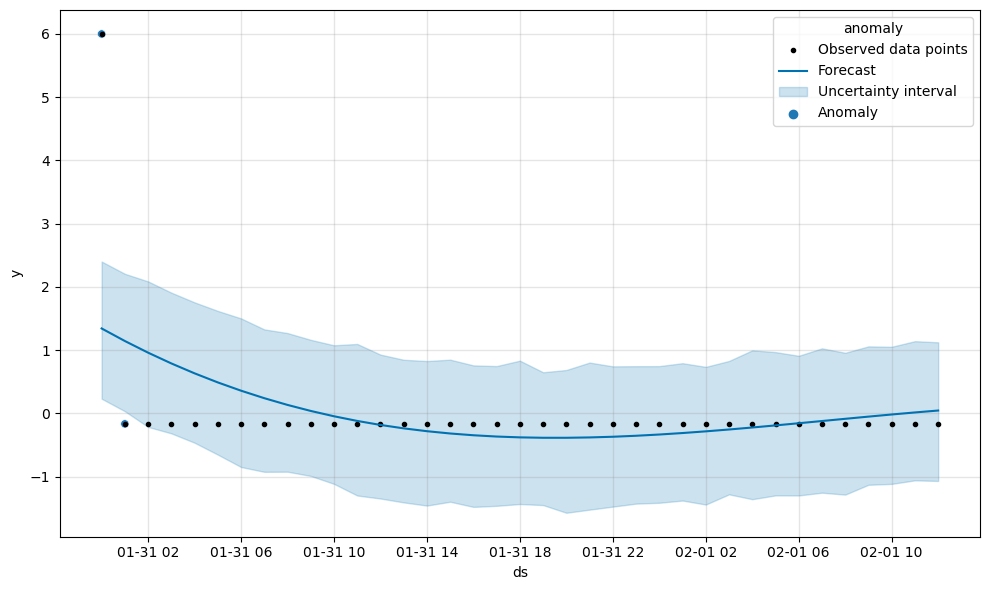

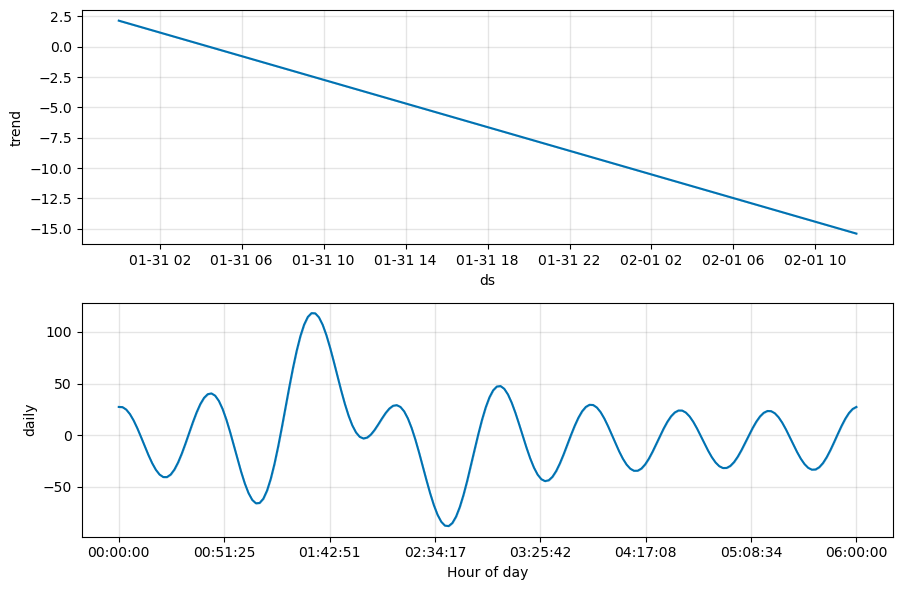

In [37]:
#PAF024 2023-02-01 06:16:00.0000000
df = getDatasetForSite(ztedf,lables,'PAF024','2023-02-02',72)
df = dataPreprocessing(df)
forecast, dfout, dsy_data = getOutlier(df,1)

#dfout = dfout.dropna()
# Visualize the anomalies
#sns.scatterplot(x='ds', y='y', data=dfout, hue='anomaly')
#sns.lineplot(x='ds', y='yhat', data=dfout, color='black')

In [38]:
# Check MAE value
performance_MAE = mean_absolute_error(dfout['y'], dfout['yhat'])
print(f'The MAE for the model is {performance_MAE}')
# Check MAPE value
performance_MAPE = mean_absolute_percentage_error(dfout['y'], dfout['yhat'])
print(f'The MAPE for the model is {performance_MAPE}')

The MAE for the model is 0.39177179552435115
The MAPE for the model is 1.6163202699692825


In [40]:
from sklearn.metrics import mean_squared_error
performance_MSE = mean_squared_error(dfout['y'], dfout['yhat'])
print(f'The MAE for the model is {performance_MAE}')

The MAE for the model is 0.39177179552435115


In [41]:
dfout

,ds,y,yhat,yhat_lower,yhat_upper,anomaly
0,2023-01-31 00:00:00,6.000000,1.342373,0.230932,2.400785,Anomaly
1,2023-01-31 01:00:00,-0.166667,1.143724,0.033267,2.206943,Anomaly
2,2023-01-31 02:00:00,-0.166667,0.959453,-0.215138,2.086339,valid
3,2023-01-31 03:00:00,-0.166667,0.789161,-0.317009,1.908736,valid
4,2023-01-31 04:00:00,-0.166667,0.632442,-0.465103,1.754820,valid
5,2023-01-31 05:00:00,-0.166667,0.488881,-0.653295,1.619792,valid
6,2023-01-31 06:00:00,-0.166667,0.358059,-0.848964,1.501359,valid
7,2023-01-31 07:00:00,-0.166667,0.239546,-0.925255,1.327637,valid
8,2023-01-31 08:00:00,-0.166667,0.132908,-0.923286,1.269558,valid
9,2023-01-31 09:00:00,-0.166667,0.037704,-0.990051,1.162451,valid
